# Section 4: Human-in-the-Loop with LangGraph Primitives

In Section 3, we built a supervisor using `create_agent` that routes queries to specialized sub-agents. However, for some queries like _"Whats the status of my recent order?"_, we need to verify the customer's identity first.

In this section, we'll add a **verification layer** using LangGraph primitives that:
- Classifies whether a query needs identity verification
- Pauses execution to collect customer email (HITL)
- Validates the email against our customer database
- Retries up to 3 times if email isn't found
- Skips verification on follow-up questions in the same thread
- Routes to our Section 3 supervisor for the actual query handling

**Key Insight:** We keep the sub-agents simple (`create_agent`), but add sophisticated orchestration with LangGraph.

## 1. Setup

Load environment variables and necessary imports.

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

## 2. Reuse Agents from Section 3

We've refactored ALL agents from Section 3 (Database, Documents, and Supervisor) into the `agents/` directory as factory functions. This demonstrates code reuse and keeps our notebooks clean.

**📦 Factory Pattern Benefits:**
- Fresh checkpointer for each agent (no state pollution)
- Independent memory per instantiation
- Clean slate for each notebook run

**🎓 Pedagogical Note:** Section 3 showed you HOW to build these agents. Now we're demonstrating how to architect reusable, production-ready code.

In [2]:
from agents import create_db_agent, create_docs_agent, create_supervisor_agent

# Instantiate sub-agents
db_agent = create_db_agent()
docs_agent = create_docs_agent()

# Instantiate supervisor agent (which wraps the sub-agents as tools)
supervisor_agent = create_supervisor_agent(db_agent, docs_agent)

print("✓ All agents loaded from agents/ directory")
print("  - Database Agent: Handles structured data queries")
print("  - Documents Agent: Searches product docs and policies")
print("  - Supervisor Agent: Routes queries to appropriate specialist")

✓ All agents loaded from agents/ directory
  - Database Agent: Handles structured data queries
  - Documents Agent: Searches product docs and policies
  - Supervisor Agent: Routes queries to appropriate specialist


## 3. Build Verification Layer with LangGraph Primitives

Now we'll add a verification layer that sits **in front of** the supervisor. This layer:
- Checks if verification is needed
- Pauses to collect customer email
- Validates against database
- Retries if email not found
- Skips verification on follow-ups


### State Schema

Since we're now collecting and storing information about the customer, we need to make sure this information is persisted in our agent's state.

In [3]:
from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


# State schema for the verification graph
class SupervisorState(TypedDict):
    """State for verification graph with HITL.

    Note: 'messages' key is shared with the supervisor subgraph!
    """

    messages: Annotated[
        list[AnyMessage], add_messages
    ]  # Conversation history (shared key)
    customer_id: str | None  # Set after successful verification
    verification_attempts: int  # Counter for retry loop

### Define Graph Nodes

We'll create 3 nodes:
1. **query_router**: Route based on verification needs (checks state + classifies if needed)
2. **verify_customer**: Pause for email (HITL), lookup in database, retry if needed
3. **supervisor (subgraph)**: The supervisor we created above handles the actual query

#### Node 1: Query Router

The "Query Router" node makes a decision about whether identity verification is required to answer the user's question.

It inspects the agent's state and the user's latest message to determine:
1. if the customer should be prompted for verification (such as when asking for information about a particular order), or 
2. if the request can proceed directly to the supervisor agent (for general questions or public information).


We'll use an LLM with structured output to classify each user message to determine if it requires verification, so lets set that up first:

In [4]:
import pprint
from pydantic import BaseModel, Field
from langchain.chat_models import init_chat_model


# Pydantic model for structured LLM output
class QueryClassification(BaseModel):
    """Classification of whether customer identity verification is required."""

    reasoning: str = Field(
        description="Brief explanation of why verification is or isn't needed"
    )
    requires_verification: bool = Field(
        description="True if the query requires knowing customer identity (e.g., 'my orders', 'my account', 'my purchases'). False for general questions (product info, policies, how-to questions)."
    )


def classify_query_intent(query: str) -> bool:
    """Classify whether a query requires customer identity verification.

    Args:
        query: The user's query string

    Returns:
        True if verification is required, False otherwise
    """
    llm = init_chat_model("anthropic:claude-haiku-4-5")

    # Create structured LLM
    structured_llm = llm.with_structured_output(schema=QueryClassification)

    classification_prompt = """Analyze the user's query to determine if it requires knowing their customer identity in order to answer the question."""

    # Get structured classification
    classification = structured_llm.invoke(
        [
            {"role": "system", "content": classification_prompt},
            {"role": "user", "content": query},
        ]
    )

    return classification

In [5]:
test = classify_query_intent("Whats the status of my recent order?")
pprint.pprint(test.model_dump())

{'reasoning': 'This query asks about "my recent order," which is personal '
              'account-specific information. To answer this question, I would '
              "need to know the customer's identity to retrieve their order "
              'history and status. This requires customer identity '
              'verification.',
 'requires_verification': True}


Now we can leverage our `classify_query_intent` tool in a node to intelligently decide when to route users to identity verification versus letting them skip directly to the supervisor agent for general questions.

In [6]:
from langgraph.types import Command
from typing import Literal


# Node 1: Query Router
def query_router(
    state: SupervisorState,
) -> Command[Literal["verify_customer", "supervisor_agent"]]:
    """Route based on verification needs.

    Logic:
    1. If customer already verified from earlier in the thread → supervisor_agent
    2. If query needs verification → verify_customer
    3. Otherwise → supervisor_agent
    """

    # Already verified? Skip to supervisor agent
    if state.get("customer_id"):
        return Command(goto="supervisor_agent")

    # Not already verified - classify query to see if verification is needed
    last_message = state["messages"][-1]
    intent_classification = classify_query_intent(last_message.content)

    # Route based on classification
    if intent_classification.requires_verification:
        return Command(goto="verify_customer")
    return Command(goto="supervisor_agent")


print("✓ Node 1: query_router defined (combines routing + classification)")

✓ Node 1: query_router defined (combines routing + classification)


#### Node 2: Verify Customer

In [7]:
import sqlite3
from pathlib import Path
from typing import Literal, NamedTuple
from langgraph.types import Command, interrupt
from langgraph.graph import END
from langchain_core.messages import AIMessage

DB_PATH = Path("../../data/structured/techhub.db")


class CustomerInfo(NamedTuple):
    """Customer information returned from validation."""

    customer_id: str
    customer_name: str


def validate_customer_email(email: str) -> CustomerInfo | None:
    """Validate email format and lookup customer in database.

    Args:
        email: Email address to validate

    Returns:
        CustomerInfo with customer_id and customer_name if valid, None otherwise
    """
    # Check email format
    if not email or "@" not in email:
        return None

    # Lookup in database
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()
    cursor.execute("SELECT customer_id, name FROM customers WHERE email = ?", (email,))
    result = cursor.fetchone()
    conn.close()

    if not result:
        return None

    return CustomerInfo(customer_id=result[0], customer_name=result[1])

In [8]:
# Node 2: Verify Customer (HITL)
def verify_customer(
    state: SupervisorState,
) -> Command[Literal["verify_customer", "supervisor_agent", END]]:
    """Verify customer identity using email with retry support.

    Demonstrates the human-in-the-loop pattern:
    - Pauses execution to collect email via interrupt()
    - Validates the email and retries if invalid
    - Routes back to itself if invalid email (max 3 attempts)
    - Proceeds to supervisor_agent on success
    """
    # Pause and collect email (CORE HITL PATTERN)
    email = interrupt(
        {"prompt": "Please provide your email:", "type": "email_verification"}
    )

    # Validate the email (format check + database lookup)
    customer = validate_customer_email(email)

    # If the email is invalid, we'll retry up to 3 times
    if not customer:
        # Check max attempts before retrying
        attempts = state.get("verification_attempts", 0)
        if attempts >= 2:
            failure_msg = AIMessage(
                content="Unable to verify your account. Please contact support@techhub.com"
            )
            return Command(
                update={"messages": state["messages"] + [failure_msg]}, goto=END
            )

        # Retry
        return Command(
            update={"verification_attempts": attempts + 1},
            goto="verify_customer",
        )

    # Success - proceed to supervisor_agent
    return Command(
        update={"customer_id": customer.customer_id},
        goto="supervisor_agent",
    )


print("✓ Node 2: verify_customer defined (HITL with retry loop)")

✓ Node 2: verify_customer defined (HITL with retry loop)


### Build and Compile the Verification Graph

Now we wire everything together:
- Add all nodes (including supervisor agent as a subgraph node)
- Set entry point
- Compile with checkpointer (REQUIRED for interrupt())

In [9]:
from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# Build the verification graph
workflow = StateGraph(SupervisorState)

# Add nodes
workflow.add_node("query_router", query_router)
workflow.add_node("verify_customer", verify_customer)
workflow.add_node("supervisor_agent", supervisor_agent)  # Add supervisor as subgraph!

# Set entry point
workflow.add_edge(START, "query_router")

# Compile with checkpointer (REQUIRED for interrupt)
verification_graph = workflow.compile(checkpointer=MemorySaver())

print("✓ Verification graph compiled!")
print("\n📊 Graph structure:")
print("   START → query_router → verify_customer → supervisor_agent_agent → END")
print("              ↓                   ↓                          ")
print("      (if verified or       (HITL retry loop)               ")
print("       general query)            ↓                          ")
print("              ↓              supervisor                     ")
print("          supervisor                                        ")

✓ Verification graph compiled!

📊 Graph structure:
   START → query_router → verify_customer → supervisor_agent_agent → END
              ↓                   ↓                          
      (if verified or       (HITL retry loop)               
       general query)            ↓                          
              ↓              supervisor                     
          supervisor                                        


### Visualize the Graph

Let's see what we built:

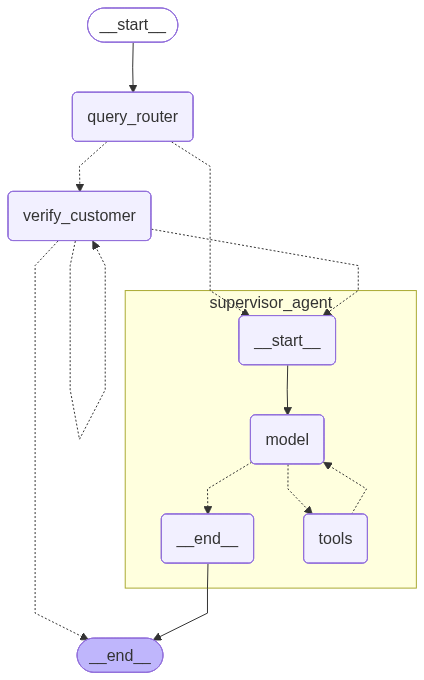

In [51]:
from IPython.display import Image

display(Image(verification_graph.get_graph(xray=True).draw_mermaid_png()))

## 4. Test the Verification Graph

Let's test all four scenarios:
1. **General query** - No verification needed
2. **Personal query** - Verification with successful email
3. **Personal query with retry** - Invalid email, then valid email
4. **Follow-up query** - Verification skipped (already verified in thread)

### Scenario 1: General Query (No HITL)

Queries about products or policies don't need customer identity verification.

In [20]:
import uuid
from langchain_core.messages import HumanMessage

# New thread for this scenario
thread_id_1 = str(uuid.uuid4())
config_1 = {"configurable": {"thread_id": thread_id_1}}

result = verification_graph.invoke(
    {"messages": [HumanMessage(content="Hi")]}, config=config_1
)

In [21]:
result

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='0c4de60b-01d9-4985-b65f-772f73470c67'),
  AIMessage(content="Hello! 👋 Welcome to TechHub customer support! \n\nI'm here to help you with any questions about your orders, products, or our policies. What can I assist you with today?", additional_kwargs={}, response_metadata={'id': 'msg_0145WPq44D4YTCQfnWrYzKZj', 'model': 'claude-haiku-4-5-20251001', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 966, 'output_tokens': 46, 'server_tool_use': None, 'service_tier': 'standard'}, 'model_name': 'claude-haiku-4-5-20251001', 'model_provider': 'anthropic'}, id='lc_run--d62b1322-98bb-4cee-8422-de0bc20cf82e-0', usage_metadata={'input_tokens': 966, 'output_tokens': 46, 'total_tokens': 1012, 'input_token_details': {'cache_read': 0, 'cache_c

In [22]:
result = verification_graph.invoke(
    {"messages": [HumanMessage(content="whats 2+2")]}, config=config_1
)
result

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='0c4de60b-01d9-4985-b65f-772f73470c67'),
  AIMessage(content="Hello! 👋 Welcome to TechHub customer support! \n\nI'm here to help you with any questions about your orders, products, or our policies. What can I assist you with today?", additional_kwargs={}, response_metadata={'id': 'msg_0145WPq44D4YTCQfnWrYzKZj', 'model': 'claude-haiku-4-5-20251001', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 966, 'output_tokens': 46, 'server_tool_use': None, 'service_tier': 'standard'}, 'model_name': 'claude-haiku-4-5-20251001', 'model_provider': 'anthropic'}, id='lc_run--d62b1322-98bb-4cee-8422-de0bc20cf82e-0', usage_metadata={'input_tokens': 966, 'output_tokens': 46, 'total_tokens': 1012, 'input_token_details': {'cache_creation': 0, 'cac

In [40]:
result = verification_graph.invoke(
    {"messages": [HumanMessage(content="how much was my last order?")]}, config=config_1
)
result

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='0c4de60b-01d9-4985-b65f-772f73470c67'),
  AIMessage(content="Hello! 👋 Welcome to TechHub customer support! \n\nI'm here to help you with any questions about your orders, products, or our policies. What can I assist you with today?", additional_kwargs={}, response_metadata={'id': 'msg_0145WPq44D4YTCQfnWrYzKZj', 'model': 'claude-haiku-4-5-20251001', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 966, 'output_tokens': 46, 'server_tool_use': None, 'service_tier': 'standard'}, 'model_name': 'claude-haiku-4-5-20251001', 'model_provider': 'anthropic'}, id='lc_run--d62b1322-98bb-4cee-8422-de0bc20cf82e-0', usage_metadata={'input_tokens': 966, 'output_tokens': 46, 'total_tokens': 1012, 'input_token_details': {'cache_creation': 0, 'cac

In [41]:
result = verification_graph.invoke(
    Command(resume="sarah.chen@gmail.com"), config=config_1
)

In [42]:
result

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='0c4de60b-01d9-4985-b65f-772f73470c67'),
  AIMessage(content="Hello! 👋 Welcome to TechHub customer support! \n\nI'm here to help you with any questions about your orders, products, or our policies. What can I assist you with today?", additional_kwargs={}, response_metadata={'id': 'msg_0145WPq44D4YTCQfnWrYzKZj', 'model': 'claude-haiku-4-5-20251001', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 966, 'output_tokens': 46, 'server_tool_use': None, 'service_tier': 'standard'}, 'model_name': 'claude-haiku-4-5-20251001', 'model_provider': 'anthropic'}, id='lc_run--d62b1322-98bb-4cee-8422-de0bc20cf82e-0', usage_metadata={'input_tokens': 966, 'output_tokens': 46, 'total_tokens': 1012, 'input_token_details': {'cache_creation': 0, 'cac

In [ ]:
import uuid
from langchain_core.messages import HumanMessage

# New thread for this scenario
thread_id_1 = str(uuid.uuid4())
config_1 = {"configurable": {"thread_id": thread_id_1}}

print("Query: 'What's your return policy?'")
print("=" * 70)

result = verification_graph.invoke(
    {"messages": [HumanMessage(content="What's your return policy?")]}, config=config_1
)

# Print final response
print("\nResponse:")
print(result["messages"][-1].content)

print("\n💡 Flow: query_router (classifies as NO) → supervisor_agent_agent → END")
print("   No HITL needed for general questions!")

### Scenario 2: Personal Query with Successful Verification

Queries about "my orders" require identity verification.

**Test email:** `sarah.chen@gmail.com` (exists in database)

In [15]:
# New thread
thread_id_2 = str(uuid.uuid4())
config_2 = {"configurable": {"thread_id": thread_id_2}}

print("Query: 'Whats the status of my recent order?'")
print("=" * 70)

# First invocation - will pause at interrupt
result = verification_graph.invoke(
    {"messages": [HumanMessage(content="Whats the status of my recent order?")]},
    config=config_2,
)

print("\n⏸️  Graph PAUSED at interrupt()")
print("Prompt:", result.get("__interrupt__", {})[0].value.get("prompt"))
print(
    "\n💡 Flow so far: query_router (classifies as YES) → verify_customer (INTERRUPT)"
)

Query: 'Whats the status of my recent order?'

⏸️  Graph PAUSED at interrupt()
Prompt: Please provide your email:

💡 Flow so far: query_router (classifies as YES) → verify_customer (INTERRUPT)


In [16]:
result.get("__interrupt__")[0]

Interrupt(value={'prompt': 'Please provide your email:', 'type': 'email_verification'}, id='b77f7f19d7950cbc6a8aea2e5f2f7eca')

In [17]:
# Resume with valid email
result = verification_graph.invoke(
    Command(resume="sarah.chen@gmail.com"), config=config_2
)

print("\n✓ Verification successful!")
print("\nFull conversation:")
print("=" * 70)
for msg in result["messages"]:
    msg.pretty_print()

print(
    "\n💡 Complete flow: query_router (classifies as YES) → verify_customer (RESUME) → supervisor_agent_agent → END"
)
print(f"   Customer ID: {result.get('customer_id')}")


✓ Verification successful!

Full conversation:
================================ Human Message =================================

Whats the status of my recent order?
================================== Ai Message ==================================

I'd be happy to help you check your order status! To look up your recent order, I'll need some information from you:

1. **Your order number** (if you have it), OR
2. **Your customer/account email address**

Could you provide one of these so I can retrieve your order status for you?

💡 Complete flow: query_router (classifies as YES) → verify_customer (RESUME) → supervisor_agent_agent → END
   Customer ID: CUST-001


In [19]:
result["messages"]

[HumanMessage(content='Whats the status of my recent order?', additional_kwargs={}, response_metadata={}, id='b33387e6-9d37-410a-8bd6-18dd0350658a'),
 AIMessage(content="I'd be happy to help you check your order status! To look up your recent order, I'll need some information from you:\n\n1. **Your order number** (if you have it), OR\n2. **Your customer/account email address**\n\nCould you provide one of these so I can retrieve your order status for you?", additional_kwargs={}, response_metadata={'id': 'msg_01VurBLfvtPSZ7e2G5ziTa33', 'model': 'claude-haiku-4-5-20251001', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 975, 'output_tokens': 73, 'server_tool_use': None, 'service_tier': 'standard'}, 'model_name': 'claude-haiku-4-5-20251001', 'model_provider': 'anthropic'}, id='lc_run--2e61ce06-7c87-437e-b940-b01d631

### Scenario 3: Personal Query with Retry (Invalid Email)

What happens when the user provides an invalid email? The graph retries!

In [ ]:
# New thread
thread_id_3 = str(uuid.uuid4())
config_3 = {"configurable": {"thread_id": thread_id_3}}

print("Query: 'Show me my recent purchases'")
print("=" * 70)

# First invocation - pauses
result = verification_graph.invoke(
    {"messages": [HumanMessage(content="Show me my recent purchases")]}, config=config_3
)

print("\n⏸️  ATTEMPT 1: Graph paused")
print("Prompt:", result.get("__interrupt__", {}).get("value", {}).get("prompt"))

In [ ]:
# Resume with INVALID email (not in database)
result = verification_graph.invoke(Command(resume="wrong@email.com"), config=config_3)

print("\n⏸️  ATTEMPT 2: Email not found - graph paused again with error message")
print("Prompt:", result.get("__interrupt__", {}).get("value", {}).get("prompt"))
print("\n💡 The node ROUTED BACK TO ITSELF (verify_customer → verify_customer)")
print("   Attempt counter incremented: 0 → 1")

In [ ]:
# Resume with VALID email
result = verification_graph.invoke(
    Command(resume="sarah.chen@gmail.com"), config=config_3
)

print("\n✓ Verification successful on second attempt!")
print("\nFinal response:")
print(result["messages"][-1].content)

print("\n💡 Retry loop in action!")
print("   Attempt 1: wrong@email.com → verify_customer (retry)")
print("   Attempt 2: sarah.chen@gmail.com → supervisor_agent (success)")

### Scenario 4: Follow-up Query (Skip Verification)

Once verified in a thread, follow-up queries skip verification entirely!

In [ ]:
# Use the same thread from Scenario 2 (already verified)
print("Query: 'What about orders from last month?'")
print("Thread ID:", thread_id_2, "(same as Scenario 2)")
print("=" * 70)

result = verification_graph.invoke(
    {"messages": [HumanMessage(content="What about orders from last month?")]},
    config=config_2,  # Reuse config from Scenario 2
)

print("\nResponse:")
print(result["messages"][-1].content)

print("\n💡 Flow: query_router (customer_id exists!) → supervisor_agent_agent → END")
print("   Skipped: classify_query and verify_customer!")
print(f"   Customer ID still in state: {result.get('customer_id')}")

## Key Takeaways

### LangGraph Primitives Demonstrated

1. **StateGraph** - Custom state schema with domain-specific fields
   - `messages`: Shared with supervisor subgraph
   - `customer_id`: Verification status
   - `verification_attempts`: Retry logic control

2. **Nodes** - Modular functions that operate on state
   - `query_router`: Combines routing logic (checks state + classifies)
   - `verify_customer`: HITL with retry loop
   - `supervisor`: Subgraph node (compiled graph from Section 3)

3. **Command** - Combines state updates with routing decisions
   ```python
   return Command(
       update={"customer_id": "CUST-001"},
       goto="supervisor_agent"
   )
   ```

4. **interrupt()** - Pause execution for human input
   - MUST come first in the node function
   - Everything before it re-runs on resume
   - Requires checkpointer to work

5. **Checkpointer** - State persistence across turns
   - Required for `interrupt()` to work
   - Enables conversation memory
   - Automatically propagated to subgraphs

6. **Subgraphs** - Compose graphs as nodes
   - Reuse Section 3's supervisor as a node
   - Shared state keys (`messages`)
   - Clean separation of concerns

### When to Use What

| Pattern | Use When... |
|---------|-------------|
| **`create_agent`** | Simple agents, standard tool loops, straightforward routing |
| **LangGraph StateGraph** | Conditional HITL, custom state, complex orchestration, retry loops |
| **Hybrid (this section!)** | Keep agents simple, add sophisticated orchestration layer |

### Retry Loop Pattern

The `verify_customer` node demonstrates a powerful pattern:
```python
def verify_customer(state):
    attempts = state.get("verification_attempts", 0)
    
    if attempts >= 3:
        return Command(update={...}, goto=END)  # Max attempts
    
    email = interrupt(...)  # Pause for input
    
    if not valid(email):
        return Command(
            update={"verification_attempts": attempts + 1},
            goto="verify_customer"  # RETRY: route back to self!
        )
    
    # Success
    return Command(update={...}, goto="supervisor_agent")
```

### Architecture Benefits

**✅ Separation of Concerns:**
- Verification layer: Handles HITL and customer identity
- Supervisor: Routes to appropriate specialists
- Sub-agents: Execute specific tasks

**✅ Reusability:**
- Section 3's supervisor agent works unchanged
- Sub-agents remain simple with `create_agent`
- Verification logic isolated in LangGraph layer

**✅ Maintainability:**
- Update verification rules without touching supervisor
- Change max retry attempts in one place
- Clear flow visible in graph structure

### Module 1 Complete! 🎉

You've now built:
1. **Section 1:** Manual tool calling (foundation)
2. **Section 2:** `create_agent` abstraction (simplification)
3. **Section 3:** Multi-agent with supervisor (specialization)
4. **Section 4:** LangGraph primitives + HITL (sophistication) ✅

**Next Steps:**
- **Module 2:** Evaluate this system to find weaknesses
- **Module 3:** Deploy to production with LangGraph Cloud

### Additional Resources

- [LangGraph Documentation](https://docs.langchain.com/oss/python/langgraph)
- [Thinking in LangGraph](https://docs.langchain.com/oss/python/langgraph/thinking-in-langgraph)
- [Subgraphs Guide](https://docs.langchain.com/oss/python/langgraph/use-subgraphs)
- [Human-in-the-Loop Patterns](https://docs.langchain.com/oss/python/langgraph/interrupts)
